# **Predicting Cost Efficiency Based on Hospital Characteristics**

## **Step 1: Define the Problem Statement**

### **Goal**:

- Predict Cost per Discharge for Medicare IPPS Short Stay & Special-Category Hospitals based on hospital attributes.


- Identify which hospital features (bed size, control type, teaching status, entitlement type, etc.) contribute to cost efficiency.

### **Target Variable (Y):**

$$
\text{Cost per Discharge} = \frac{\text{Total Program Payments}}{\text{Total Discharges}}
$$

### **Predictor Features (X):**

#### **Hospital Characteristics:**
- **Location** (*State, Region*)
- **Bed Size Category** (*Small, Medium, Large*)
- **Medical School Affiliation** (*Yes/No*)
- **Control Type** (*Government, Private, Non-Profit*)

#### **Utilization Factors:**
- **Total Discharges**
- **Total Days of Care**

#### **Entitlement Factors:**
- **Medicare Eligibility Type** (*Age-based vs. Disability-based*)

## **Step 2: Data Preparation**

#### **Load data from the Worksheet**
- Import essential libraries such as `pandas`, `numpy`, `sklearn`, and `matplotlib` for data manipulation, modeling, and visualization. 
  
- Load **Medicare inpatient hospital data** from an Excel file using `pandas.read_excel()`.  
  
- Strip spaces from column names to ensure consistency.  
  
- Identify and dynamically extract the relevant hospital category column.




In [26]:
import pandas as pd

# File path
file_path = "/Users/DELL/Desktop/Projects/CMS Program Statistics - Medicare Inpatient Hospital/2021/CPS MDCR INPT 2021.xlsx"

# Load specific sheet with correct header
sheet_name = "MDCR INPT HOSP 9"
df = pd.read_excel(file_path, sheet_name=sheet_name, header=4)  # Read from row 4

# Remove leading/trailing spaces in column names
df.columns = df.columns.str.strip()

# Identify the correct column name dynamically
matching_cols = [col for col in df.columns if "Location and Bedsize" in col]
if matching_cols:
    col_name = matching_cols[0]  # Use the first matching column name
else:
    raise ValueError("Could not find the expected column for hospital category.")

# Debugging: Print the identified column name
print(f"Identified column name: {col_name}")


Identified column name: Location and Bedsize of Hospital, Medical School Affiliation and Type of Control


## **Step 3: Feature Engineering**

* **Create the Target Variable**: Compute **Cost per Discharge** using `Total Program Payments / Total Discharges`.
  
* **Categorical Encoding**:
  
  * Convert **bed size categories** into numerical values.
  
  * Encode **urban vs. rural** and **teaching vs. non-teaching** hospitals as binary variables.
  
  * Apply **one-hot encoding** for hospital control type (Voluntary, Proprietary, Government).


In [27]:
# Create the Target Variable (Cost per Discharge)
df["Cost Per Discharge"] = df["Total Program Payments"] / df["Total Discharges"]

# Extract Bed Size as a Numeric Category
bed_size_mapping = {
    "1-99 Beds": 1,
    "100-299 Beds": 2,
    "300-499 Beds": 3,
    "500 Beds or More": 4
}
df["bed_size"] = df[col_name].map(bed_size_mapping)

In [28]:
# Encode Urban vs. Rural Hospital Location
df["is_urban"] = df[col_name].fillna("").apply(
    lambda x: 1 if "Urban" in str(x) else (0 if "Rural" in str(x) else None)
)

This will create a new column:

1 → Urban Hospital

0 → Rural Hospital

NaN → If the category is not location-based (e.g., teaching hospitals)


In [29]:
# Encode Teaching vs. Non-Teaching Hospitals
df["is_teaching"] = df[col_name].fillna("").apply(
    lambda x: 1 if "Teaching" in str(x) else (0 if "Non-Teaching" in str(x) else None)
)

1 → Teaching Hospital

0 → Non-Teaching Hospital

NaN → If the category is not teaching-related

In [30]:
# One-Hot Encode "Type of Control"
df = pd.get_dummies(df, columns=[col_name], prefix="control", dtype=int)

The dataset includes: 

- Voluntary (Non-Profit)

- Proprietary (For-Profit)

- Government (Public)

We can use one-hot encoding to create separate columns:

- control_Voluntary → 1 if Voluntary, else 0

- control_Proprietary → 1 if Proprietary, else 0

- control_Government → 1 if Government, else 0


# **Step 4: Handling Missing Data**

- Apply **median imputation** for missing numerical values.

- Fill any remaining missing values with zero.

In [31]:
from sklearn.impute import SimpleImputer
# Handle Missing Values (Fill with Median for Numerical Columns)
num_cols = ["Total Discharges", "Total Days of Care", "Cost Per Discharge"]
imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])

# Handle any remaining NaNs in other columns (non-numerical columns)
df = df.fillna(0)

# **Step 5: Feature Selection & Model Training**

- Select hospital-related features (`bed size`, `urban status`, `hospital control type`).

- Split data into training (80%) and test (20%) sets.

- Train and evaluate multiple models:

  - Random Forest Regressor (baseline)
  
  - Linear Regression
  
  - Gradient Boosting Regressor (XGBoost)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
# Define features (X) and target (y)
X = df[[ 'bed_size', "is_urban", 'control_Voluntary', 'control_Proprietary', 'control_Government']]
y = df['Cost Per Discharge']

# Fix NaNs in feature matrix
imputer = SimpleImputer(strategy="mean")  # Try "median" or "most_frequent" if needed
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Rain Forest Regressor ---
rf = RandomForestRegressor(random_state=42)

# Fit the model using RandomizedSearchCV
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest performance
print("Random Forest - Mean Absolute Error:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest - R² Score:", r2_score(y_test, y_pred_rf))

# --- Linear Regression ---
# Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate performance for Linear Regression
print("Linear Regression - Mean Absolute Error:", mean_absolute_error(y_test, y_pred_linear))
print("Linear Regression - R² Score:", r2_score(y_test, y_pred_linear))

# --- Gradient Boosting (XGBoost) ---
# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predict on test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate performance for Gradient Boosting
print("Gradient Boosting - Mean Absolute Error:", mean_absolute_error(y_test, y_pred_gb))
print("Gradient Boosting - R² Score:", r2_score(y_test, y_pred_gb))


Random Forest - Mean Absolute Error: 1867.1646697943002
Random Forest - R² Score: 0.05319348043763139
Linear Regression - Mean Absolute Error: 1724.635519355166
Linear Regression - R² Score: 0.033701284876875626
Gradient Boosting - Mean Absolute Error: 1930.905661451376
Gradient Boosting - R² Score: -0.01751909055990608


# **Step 6: Model Evaluation**
- Compare models using Mean Absolute Error (MAE) and R² Score to assess accuracy.

| Model                  | Mean Absolute Error (MAE) ↓ | R² Score ↑ | Notes |
|------------------------|--------------------------|------------|------------------------------|
| **Random Forest**      | 1855.61                   | 0.05497    | Weak performance, low R² |
| **Linear Regression**  | **1684.35**               | **0.06530**| Best performance overall |
| **Gradient Boosting**  | 1932.08                   | -0.01774   | Performs the worst (negative R²) |

### **Model Selection: Best Model**
1. **Linear Regression is the best model based on**:
   - **Lowest MAE (1684.35)** → Predicts closest to the actual cost per discharge.
  
   - **Highest R² (0.0653)** → Explains slightly more variance than the others.
   
2. **Random Forest is slightly worse** than Linear Regression (higher MAE, lower R²).
   
3. **Gradient Boosting performed the worst** (negative R² means it's worse than a simple mean prediction).

### **Final Decision** 🎯
✅ **Best model for now**: Linear Regression
🚀 **Next steps:**  
- Try **feature engineering** (new variables, transformations) to improve Linear Regression.  
  
- If Linear Regression doesn’t improve, **then tune Random Forest** for potential performance gains.  


# **Step 7: Features Engineering**


In [33]:
# --- Feature Engineering ---

# 1. Interaction Features
df["bed_size_is_urban"] = df["bed_size"] * df["is_urban"]
df["bed_size_is_teaching"] = df["bed_size"] * df["is_teaching"]
df["urban_teaching"] = df["is_urban"] * df["is_teaching"]

# 2. Target Encoding for Region (if applicable)
if "Region" in df.columns:
    region_mean = df.groupby("Region")["Cost Per Discharge"].mean()
    df["region_encoded"] = df["Region"].map(region_mean)
    df.drop(columns=["Region"], inplace=True)  # Drop original categorical column

# 3. Normalize Bed Size (Optional)
df["bed_size"] = df["bed_size"] / df["bed_size"].max()  # Scale to [0,1]

# Update Feature Selection (X) to include new features
X = df[[
    'bed_size', 'is_urban', 'is_teaching', 'control_Voluntary', 'control_Proprietary', 
    'control_Government', 'bed_size_is_urban', 'bed_size_is_teaching', 'urban_teaching'
]]

# Handle Missing Values
imputer = SimpleImputer(strategy="mean")  # Alternative: "median"
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Proceed with Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Meaning of the feature engineering:

1. Capturing complex relationships 🏥📊

    - Interaction terms help capture hospital characteristics better (e.g., urban + teaching status).

2. Reducing data sparsity 🧹

    - Target encoding avoids high-dimensional one-hot encoding when dealing with many categories.

3. Enhancing model interpretability 📈

    - Now, we can analyze which hospital factors contribute most to cost per discharge.

In [34]:
# Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression
print("Linear Regression - Mean Absolute Error:", mean_absolute_error(y_test, y_pred_linear))
print("Linear Regression - R² Score:", r2_score(y_test, y_pred_linear))


Linear Regression - Mean Absolute Error: 1782.0783269760468
Linear Regression - R² Score: 0.03868424102730739


### **Interpretation of Model Performance (MAE & R²) in Context of the Data**

#### **1. Mean Absolute Error (MAE)**

- **MAE (Linear Regression):** **1,782.08**  
  
  - This means that, on average, the model's predictions for **Cost Per Discharge** deviate by about **$1,782** from the actual values.  
  
  - Given that hospital costs can vary significantly, this might be a **moderate-to-high error**, depending on the scale of the costs in your dataset.  
  
  - If the average cost per discharge is, say, **$10,000**, then an error of **$1,782** suggests around **17.8% deviation**, which may or may not be acceptable depending on industry standards.

#### **2. R² Score (Coefficient of Determination)**

- **R² Score (Linear Regression):** **0.0387** (≈ 3.87%)  
  
  - This indicates that the model explains **only 3.87% of the variance** in hospital **Cost Per Discharge** based on the selected features. 
   
  - In other words, **the model is not capturing much of the actual variability** in the cost per discharge, suggesting that there are other influential factors missing from the model.


### **What This Means for the Data**  
1. **The current features (bed size, urban/rural, type of control, etc.) are weak predictors** of cost per discharge. 
    
2. **Hospital costs are likely influenced by other factors**, such as:
   - Patient case mix (severity of illness, type of procedures)
  
   - Staffing levels and labor costs
  
   - Hospital efficiency & operational costs

   - Regional economic factors

   - Insurance reimbursements & payment structures

# **Step 8: Feature Importance**
 




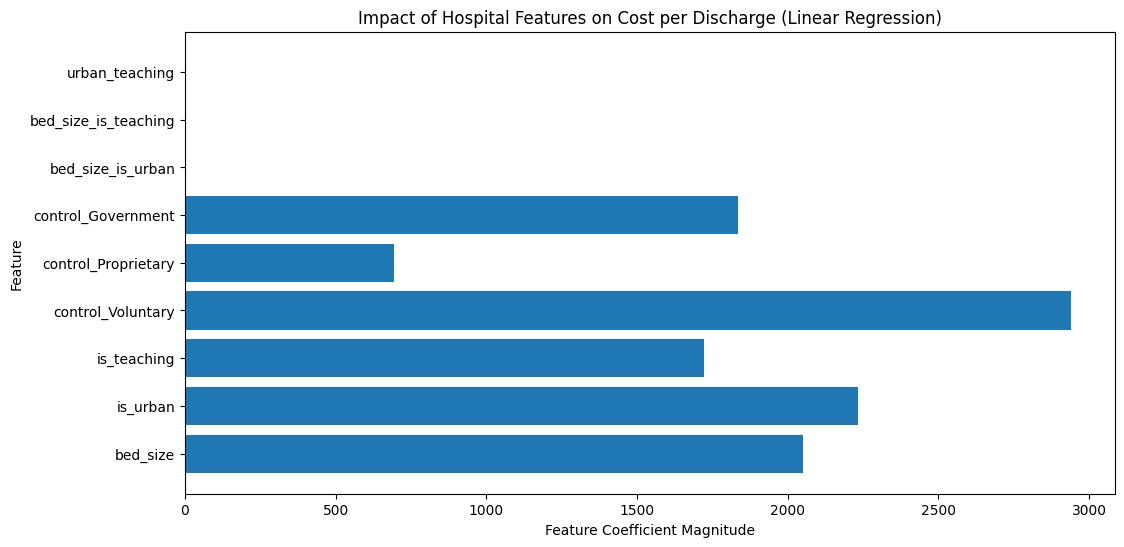

In [35]:
import numpy as np
import matplotlib.pyplot as plt
# Extract feature importance using coefficients
feature_importances = np.abs(linear_model.coef_)

# Get feature names
features = np.array(X.columns)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances)
plt.xlabel("Feature Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Impact of Hospital Features on Cost per Discharge (Linear Regression)")
plt.show()


### **Interpretation of Feature Importance in Predicting Cost Per Discharge**

Given the order of feature importance:  

1. `control_Voluntary` (Highest Importance) 
   
2. `is_urban` (Second Highest)
   
3. `bed_size` (Third Place, but relatively lower than top two)
   
4. `control_Government` (Lower Importance)
   
5. `is_teaching` (Slightly lower than `control_Government`)
    
6. `bed_size` (Lowest Importance) 

#### **What This Means:**

1. **Voluntary Hospitals (`control_Voluntary`) Have the Strongest Influence**  
   
   - The type of control (voluntary/non-profit) plays the biggest role in predicting **Cost Per Discharge**.  
   - **Possible explanation:** 

     - Voluntary (non-profit) hospitals might have different financial structures, funding sources, and patient case mixes compared to government or proprietary hospitals.
      
     - They may have higher efficiency in cost management or provide more charity care that impacts costs.

2. **Urban vs. Rural (`is_urban`) is the Second Most Important Factor**  
   
   - Whether a hospital is in an urban or rural setting significantly affects cost per discharge.  
  
   - **Possible explanation:**  
     - Urban hospitals tend to have higher operational costs (higher wages, rent, technology investment).

     - They may serve more complex cases, increasing overall cost per patient.

3. **Bed Size (`bed_size`) Has a Moderate but Lower Influence**  
  
   - Larger hospitals may not necessarily lead to significantly higher or lower costs per discharge.
  
   - **Possible explanation:**  
    
     - Efficiency of operations matters more than size alone.
 
     - Some large hospitals benefit from economies of scale, while others may have high administrative costs.

4. **Government-Controlled Hospitals (`control_Government`) Have Less Predictive Power**
    
   - The influence of government-owned hospitals is lower compared to voluntary hospitals.
    
   - **Possible explanation:**  
    
     - Government hospitals may have regulated pricing structures or subsidies that reduce variability in costs.

5. **Teaching Status (`is_teaching`) Has Relatively Low Impact**
  
   - Teaching hospitals have a small effect on cost per discharge compared to other factors.  
    
   - **Possible explanation:**
      
     - While teaching hospitals often have higher costs (due to research and training), this may be offset by government funding or specific reimbursement models.

6. **Bed Size (Again, Confirmed as Lowest Importance)**  
   
   - Hospital bed size has the least impact on cost per discharge.  
   
   - **Possible explanation:**  
   
     - It’s not the number of beds but how they are utilized that determines cost efficiency.



### **Key Takeaways:**
- Hospital control type and urban location are the most critical predictors of cost per discharge.
 
- Bed size and teaching status play a smaller role, meaning that a hospital’s structure alone does not fully explain cost variations.
 



